# MNIST Training


The training setup is the same one that has also been used by Papernot and McDaniel. For more details see their [paper](https://arxiv.org/abs/1803.04765) and their [sample code](https://github.com/cleverhans-lab/cleverhans/blob/master/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py).

In [ ]:
! pip uninstall torch torchvision -y
! pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Uninstalling torch-1.7.0+cu101:
  Successfully uninstalled torch-1.7.0+cu101
Uninstalling torchvision-0.8.1+cu101:
  Successfully uninstalled torchvision-0.8.1+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu101/torch-1.7.0%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Using cached https://download.pytorch.org/whl/cu101/torchvision-0.8.1%2Bcu101-cp36-cp36m-linux_x86_64.whl


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import platform

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0+cu101
torchvision version: 0.8.1+cu101
numpy version:       1.19.5
matplotlib version:  3.2.2
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla T4

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


Put CUDNN to deterministic and set seed values for [reproducibility reasons](https://pytorch.org/docs/stable/notes/randomness.html).

In [ ]:
random_seed = 0
torch.manual_seed(random_seed)
np.random.seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

Let's set some parameters.

In [ ]:
num_epochs = 6            # number of training epochs
batch_size_train = 500    # batch size for training
batch_size_test = 1000    # batch size for testing
learning_rate = 0.001     # learning rate for training
calibset_size = 750       # size of the calibration set (should be used for calculating a confidence score later)

log_interval = 10         # printing training statistics after 10 iterations

## Data

### Specify Dataset

Define data transform functions for training and test set.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Define training test and calibration set.

In [ ]:
# Training set
trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

# Test set and calibration set
orig_testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)
orig_testset_size = len(orig_testset)

testset_size = orig_testset_size - calibset_size
testset, calibset = torch.utils.data.random_split(orig_testset, [testset_size, calibset_size])

### Load Data

Create train, test and calibration data loader.

In [ ]:
# Create training data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=2
)

# Create test data loader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=2
)

# Create calib data loader
calibloader = torch.utils.data.DataLoader(
    calibset, batch_size=calibset_size, shuffle=False, num_workers=2
)

Print out the sizes of the datasets.

In [ ]:
print('trainset size: {}'.format(len(trainloader.dataset)))
print('testset size:  {}'.format(len(testloader.dataset)))
print('calibset size: {}'.format(len(calibloader.dataset)))

trainset size: 60000
testset size:  9250
calibset size: 750


### Display Samples

In [ ]:
def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        
        img = data * 0.3081 + 0.1307  # unnormalize
        plt.imshow(img[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(targets[i]))
        
        plt.xticks([])
        plt.yticks([])

Load a few test images and display them.

tensor shape: (1000, 1, 28, 28)


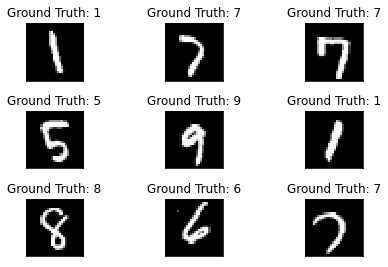

In [ ]:
dataiter = enumerate(testloader)
_, (sample_data, sample_targets) = next(dataiter)

show_samples(sample_data, sample_targets)

## Define Training and Test Functions

Let's define the functions for training and testing.

In [ ]:
def train(num_epochs, model, optim, crit, train_loader, test_loader):
    train_losses = []
    test_losses = []
    test_accs = []
    
    for epoch in range(1, num_epochs + 1):
        model, train_losses = train_one_epoch(epoch, model, optim, crit, train_loader, train_losses)
        test_losses, test_accs = test(model, crit, test_loader, test_losses, test_accs)
        
    print('Finished Training')
    return train_losses, test_losses, test_accs
    

def train_one_epoch(epoch_num, model, optim, crit, data_loader, losses):
    model.train()
    running_loss = 0.0
    
    for batch_idx, data in enumerate(data_loader):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, targets = data

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # Zero the parameter gradients
        optim.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = crit(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        
        if batch_idx % log_interval == 0:
            dataset_size = len(data_loader.dataset)
            used_samples = batch_idx * len(inputs)
            train_progress = 100. * batch_idx / len(data_loader)
            avg_batch_loss = running_loss / log_interval
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_num, used_samples, dataset_size, train_progress, avg_batch_loss
            ))
            
            losses.append(avg_batch_loss)
            running_loss = 0.0
            
    return model, losses
     
    
def test(model, crit, data_loader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in data_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
              inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += crit(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(data_loader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

## Network Architecture

Let's define the neural network based model architecture for MNIST.

In [ ]:
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5)
        self.relu3 = nn.ReLU(True)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

## Model Training

Let's train the model.

In [ ]:
# Create Model
model = MnistNet()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

# Define Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Start Training
_, _, accs = train(num_epochs, model, optimizer, criterion, trainloader, testloader)

print()
print('Accuracies: {}'.format(accs))

Using  1  GPU(s)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.229999
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.106209
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.398306
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.291384
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.224361
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.187163
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.164172
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.138616
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.116260
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.115057
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.096055
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.088089

Test set: Avg. loss: 0.000077, Accuracy: 9054/9250 (97.88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.007645
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.068021
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.080752
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.055804
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.058146
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.061231
Train Epoch: 2 [30000/60000 (50%)]	

Put model in evaluation mode.

In [ ]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

Using  1  GPU(s)


Let's test our model again to see again which accuracy we have finally reached.

In [ ]:
def test_final(model, data_loader):
    _, accs = test(model, criterion, data_loader, [], [])
    return accs[0]

In [ ]:
test_acc = test_final(model, testloader); test_acc


Test set: Avg. loss: 0.000038, Accuracy: 9162/9250 (99.05%)



99.04864864864865

Let's save the model.

In [ ]:
torch.save(model.state_dict(), "./mnist_model.pth")

In [ ]:
! ls

data  mnist_model.pth  sample_data


In [ ]:
from google.colab import files
files.download('./mnist_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>